## Install libraries to the environment

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install sklearn
%pip install faker

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight


# Generate synthetic data


In [ ]:
fake = Faker()
data = []

for _ in range(1000):
    age = fake.random_int(min=18, max=65)
    height = fake.random_int(min=150, max=220)
    weight = fake.random_int(min=50, max=200)
    bmi = weight / (height/100)**2
    ldl = fake.random_int(min=80, max=160)
    triglycerides = fake.random_int(min=50, max=300)
    glucose = fake.random_int(min=70, max=150)
    insuline = fake.random_int(min=2, max=30)
    hba1c = round(np.random.uniform(4.5, 9.0), 1) # Rango de HbA1c en %
    
    # Simulación de condiciones genéticas (5% de probabilidad)
    genetic_condition = np.random.choice([0, 1], p=[0.95, 0.05])
    
    # Simulación de Presión Arterial (PA) - rangos más amplios y realistas
    systolic_bp = fake.random_int(min=90, max=180) # Rango PA sistólica
    diastolic_bp = fake.random_int(min=60, max=110) # Rango PA diastólica

    # Simulación de Creatinina y TFG (eGFR) - rangos que reflejan función renal
    creatinine = round(np.random.uniform(0.5, 2.5), 1) # Creatinina mg/dL
    # Estimación simplificada de TFG (eGFR) - inversamente proporcional a creatinina
    egfr = max(15, round(120 - 20 * (creatinine - 0.8), 0)) # Simplificación, eGFR mL/min/1.73m^2, mínimo 15

    # Simulación de obesidad y diabetes (basado en rangos y condiciones)
    obesity_probability = 0 # Inicializar probabilidad de obesidad

    if bmi > 30:
        obesity_probability += 0.7  # Alto IMC aumenta fuertemente la probabilidad
    elif bmi >= 27 and genetic_condition == 1:
        obesity_probability += 0.6  # Cond. Genética + IMC elevado aumenta probabilidad
    elif bmi >= 25 and genetic_condition == 1:
        obesity_probability += 0.4  # Cond. Genética + IMC ligeramente elevado también aumenta
    elif bmi > 27:
         obesity_probability += 0.5  # IMC elevado por sí solo aumenta probabilidad

    if ldl > 130:
        obesity_probability += 0.3  # LDL alto aumenta probabilidad
    if triglycerides > 200:
        obesity_probability += 0.3  # Triglicéridos altos aumentan probabilidad
    if genetic_condition == 1: # Condición genética AUMENTA probabilidad de obesidad
        obesity_probability += 0.2 # Aumento adicional por condición genética

    obesity_probability = min(obesity_probability, 1) # Asegurar probabilidad entre 0 y 1
    obesity_random_factor = np.random.rand()
    obesity = 1 if obesity_probability > 0.5 + obesity_random_factor * 0.3 else 0

    diabetes_probability = 0
    if glucose > 126:
        diabetes_probability += 0.6 # Glucosa alta es un fuerte indicador
    if insuline >= 25:
        diabetes_probability += 0.5 # Insulina alta también
    if hba1c > 6.5: # HbA1c por encima del rango diagnóstico
        diabetes_probability += 0.7 # HbA1c muy importante para diagnóstico
    if genetic_condition == 1:
        diabetes_probability += 0.3 # Condición genética aumenta probabilidad

    diabetes_probability = min(diabetes_probability, 1)
    diabetes_random_factor = np.random.rand()
    diabetes = 1 if diabetes_probability > 0.5 + diabetes_random_factor * 0.35 else 0 # Ajuste de umbral para diabetes
    
    
    # Simulación de Hipertensión - Priorizando PA, luego Creatinina, luego LDL
    hypertension_probability = 0
    if systolic_bp > 140 or diastolic_bp > 90: # Criterios primarios: Presión Arterial Elevada
        hypertension_probability += 0.8 # PA alta, muy fuerte predictor
    elif systolic_bp > 130 or diastolic_bp > 80: # Pre-hipertensión también aumenta probabilidad
        hypertension_probability += 0.5 # Pre-hipertensión, riesgo moderado
    if egfr < 60: # TFG baja (indicativo de problema renal) - segundo factor en prioridad
        hypertension_probability += 0.4 # Función renal disminuida aumenta probabilidad
    if ldl > 160: # LDL muy alto - tercer factor de prioridad
        hypertension_probability += 0.3 # LDL muy elevado aumenta probabilidad
    if age > 60: # Edad avanzada - factor de riesgo adicional
        hypertension_probability += 0.2 # Edad aumenta probabilidad
    if genetic_condition == 1: # Condición genética - factor de riesgo adicional
        hypertension_probability += 0.2 # Genética también aumenta probabilidad

    hypertension_probability = min(hypertension_probability, 1)
    hypertension_random_factor = np.random.rand()
    hypertension = 1 if hypertension_probability > 0.5 + hypertension_random_factor * 0.4 else 0 # Umbral ajustado


    
    data.append({
        'edad' : age,
        'altura' : height,
        'peso' : weight,
        'imc' : bmi,
        'ldl' : ldl,
        'trigliceridos' : triglycerides,
        'glucosa_ayunas' : glucose,
        'insulina' : insuline,
        'hba1c' : hba1c,
        'condicion_genetica' : genetic_condition,
        'obesidad' : obesity,
        'diabetes' : diabetes,
        'presion_arterial_sistolica': systolic_bp, 
        'presion_arterial_diastolica': diastolic_bp, 
        'creatinina': creatinine,
        'tfg': egfr, 
        'hipertension': hypertension
        
    })
    
df = pd.DataFrame(data)
df.head()

# Preprocessing data

In [ ]:
scaler = StandardScaler()
numerical_cols = ['imc', 'ldl', 'trigliceridos', 'glucosa_ayunas', 'insulina', 'hba1c', 'presion_arterial_sistolica', 'presion_arterial_diastolica', 'creatinina', 'tfg'] # Añadir nuevas cols numéricas
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Model training

In [ ]:
# Definición de características y etiquetas
features_obesity = ['imc', 'ldl', 'trigliceridos', 'glucosa_ayunas', 'insulina', 'condicion_genetica']
labels_obesity = df['obesidad']

# Características para el modelo de diabetes - Usando glucosa, insulina, hba1c y genético
features_diabetes = ['glucosa_ayunas', 'insulina', 'hba1c', 'condicion_genetica']
labels_diabetes = df['diabetes']

features_hipertension = ['presion_arterial_sistolica', 'presion_arterial_diastolica', 'creatinina', 'ldl', 'condicion_genetica', 'edad']
labels_hipertension = df['hipertension']



# División de datos
X_train_obesity, X_test_obesity, y_train_obesity, y_test_obesity = train_test_split(df[features_obesity], labels_obesity, test_size=0.2, random_state=42, stratify=labels_obesity)
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(df[features_diabetes], labels_diabetes, test_size=0.2, random_state=42, stratify=labels_diabetes)
X_train_hipertension, X_test_hipertension, y_train_hipertension, y_test_hipertension = train_test_split(df[features_hipertension], labels_hipertension, test_size=0.2, random_state=42, stratify=labels_hipertension) # División para Hipertensión




class_weights_obesity = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_obesity), y=y_train_obesity)
class_weight_dict_obesity = dict(enumerate(class_weights_obesity))

class_weights_diabetes = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_diabetes), y=y_train_diabetes)
class_weight_dict_diabetes = dict(enumerate(class_weights_diabetes))

class_weights_hipertension = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_hipertension), y=y_train_hipertension)
class_weight_dict_hipertension = dict(enumerate(class_weights_hipertension))

# Entrenamiento de modelos (Random Forest)

obesity_model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict_obesity) 
obesity_model.fit(X_train_obesity, y_train_obesity)

model_diabetes = RandomForestClassifier(random_state=42, class_weight=class_weight_dict_diabetes)
model_diabetes.fit(X_train_diabetes, y_train_diabetes)

model_hipertension = RandomForestClassifier(random_state=42, class_weight=class_weight_dict_hipertension) # Modelo para hipertensión
model_hipertension.fit(X_train_hipertension, y_train_hipertension)



# Model evaluation

In [72]:
# Obesidad
y_pred_obesity = obesity_model.predict(X_test_obesity)
accuracy_obesity = accuracy_score(y_test_obesity, y_pred_obesity)
print(f'Precisión del modelo de obesidad: {accuracy_obesity:.2f}')
print(classification_report(y_test_obesity, y_pred_obesity))


# Diabetes
y_pred_diabetes = model_diabetes.predict(X_test_diabetes)
accuracy_diabetes = accuracy_score(y_test_diabetes, y_pred_diabetes)
print(f'Precisión del modelo de diabetes: {accuracy_diabetes:.2f}') 
print(classification_report(y_test_diabetes, y_pred_diabetes))

# Hipertensión
y_pred_hipertension = model_hipertension.predict(X_test_hipertension)
accuracy_hipertension = accuracy_score(y_test_hipertension, y_pred_hipertension)
print(f'Precisión del modelo de hipertensión: {accuracy_hipertension:.2f}')
print(classification_report(y_test_hipertension, y_pred_hipertension))

Precisión del modelo de obesidad: 0.89
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        72
           1       0.89      0.94      0.91       128

    accuracy                           0.89       200
   macro avg       0.88      0.86      0.87       200
weighted avg       0.88      0.89      0.88       200

Precisión del modelo de diabetes: 0.82
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       100
           1       0.80      0.86      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

Precisión del modelo de hipertensión: 0.87
              precision    recall  f1-score   support

           0       0.94      0.77      0.85        93
           1       0.83      0.95      0.89       107

    accuracy                           0.87       200
   macr

# Graphics about the training

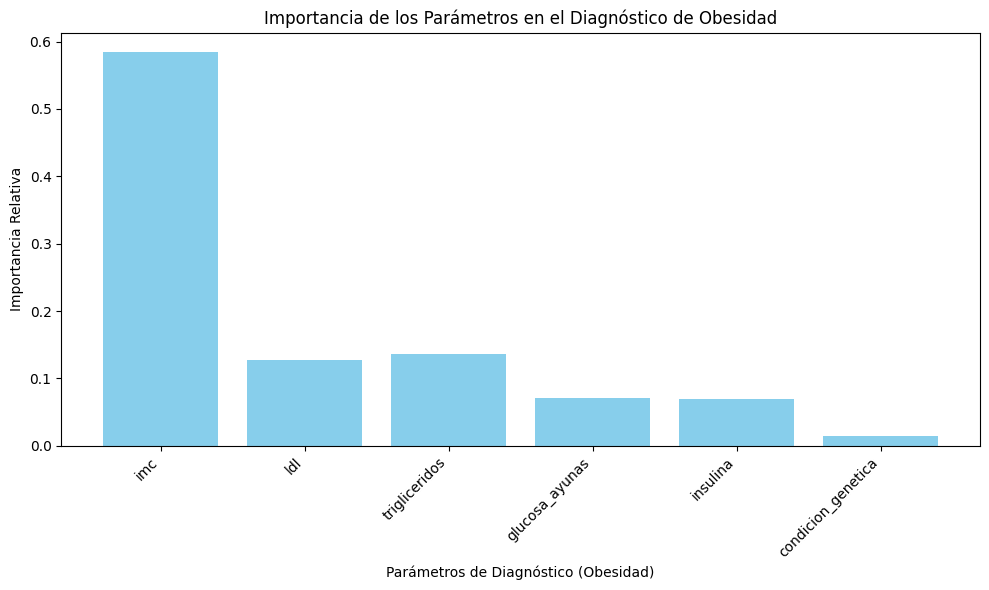

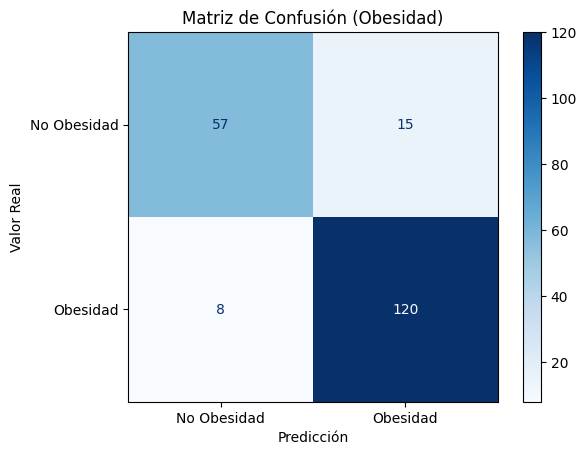

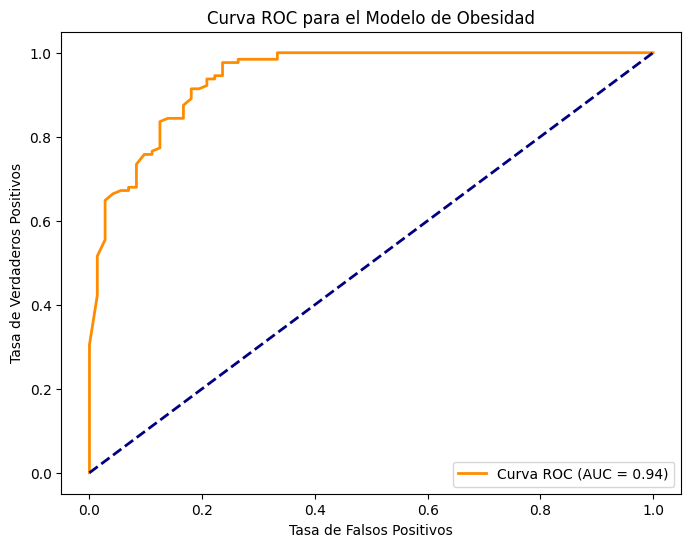

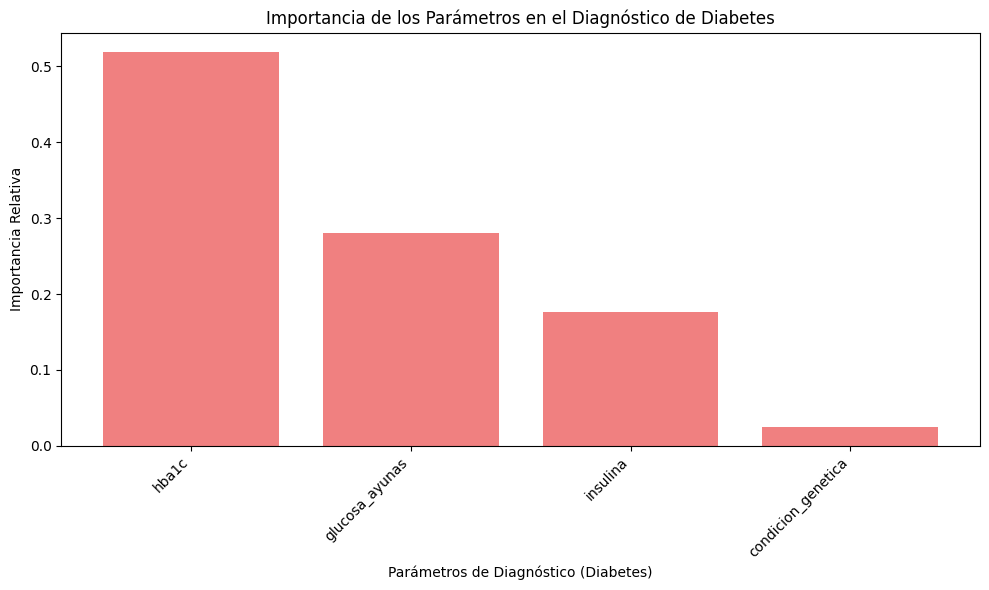

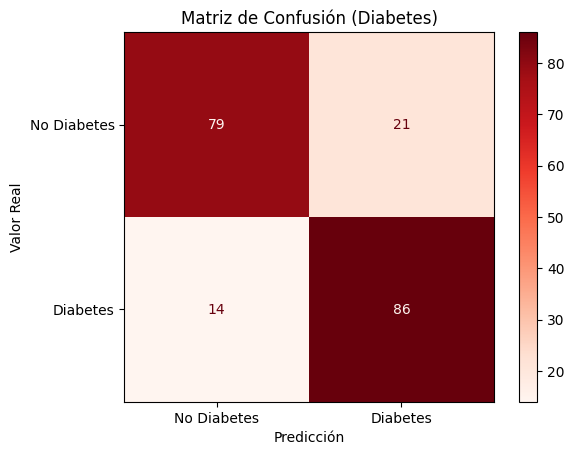

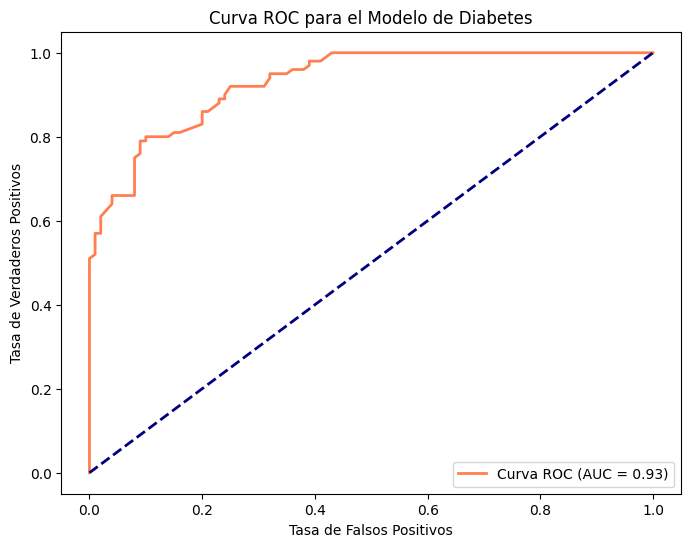

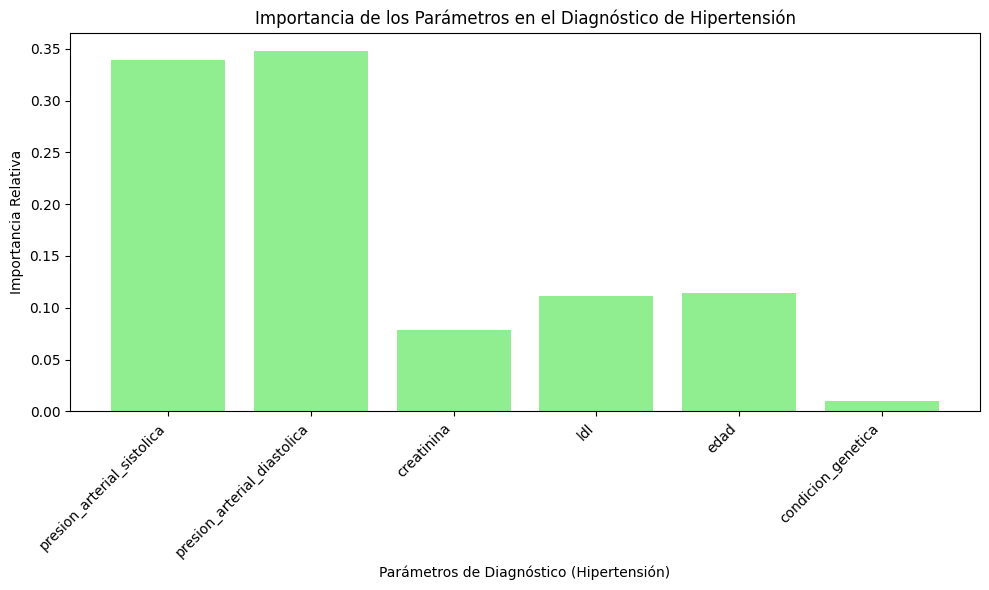

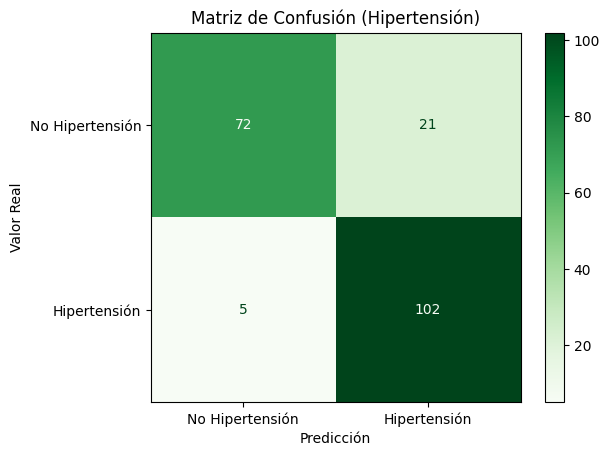

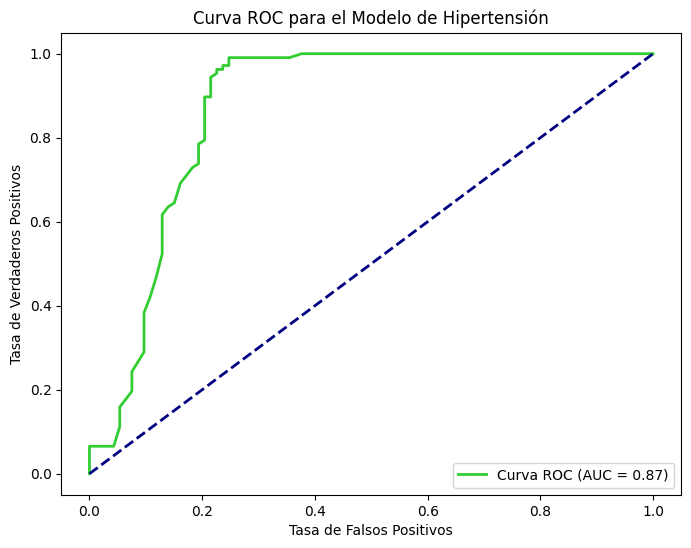

In [73]:
# --- Importancia de características (Obesidad) ---
feature_importances_obesity = obesity_model.feature_importances_
feature_names = features_obesity
importance_df_obesity = pd.DataFrame({'feature': feature_names, 'importance': feature_importances_obesity})

# Ordenar por importancia (de mayor a menor) 
importance_df_obesity = importance_df_obesity.sort_values(by='importance', ascending=False)

# Reordenar características para que coincidan con el gráfico de barras imc > ldl > trigliceridos
ordered_features = ['imc', 'ldl', 'trigliceridos']
ordered_importance = []
remaining_features_importance = []

for feature_name in ordered_features:
    if feature_name in importance_df_obesity['feature'].values:
        ordered_importance.append(importance_df_obesity[importance_df_obesity['feature'] == feature_name])

remaining_features_importance = importance_df_obesity[~importance_df_obesity['feature'].isin(ordered_features)]

ordered_importance_df = pd.concat(ordered_importance + [remaining_features_importance], ignore_index=True)


plt.figure(figsize=(10, 6))
plt.bar(ordered_importance_df['feature'], ordered_importance_df['importance'], color='skyblue')
plt.xlabel('Parámetros de Diagnóstico (Obesidad)') 
plt.ylabel('Importancia Relativa')
plt.title('Importancia de los Parámetros en el Diagnóstico de Obesidad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Matriz de Confusión (Obesidad) ---
cm_obesidad = confusion_matrix(y_test_obesity, y_pred_obesity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_obesidad, display_labels=['No Obesidad', 'Obesidad']) # Added labels
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (Obesidad)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


# --- Curva ROC y AUC (Obesidad) ---
fpr_obesidad, tpr_obesidad, _ = roc_curve(y_test_obesity, obesity_model.predict_proba(X_test_obesity)[:, 1])
roc_auc_obesidad = auc(fpr_obesidad, tpr_obesidad)

plt.figure(figsize=(8, 6))
plt.plot(fpr_obesidad, tpr_obesidad, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_obesidad:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el Modelo de Obesidad')
plt.legend(loc="lower right")
plt.show()


# --- Importancia de características (Diabetes) ---
feature_importances_diabetes = model_diabetes.feature_importances_
feature_names_diabetes = features_diabetes
importance_df_diabetes = pd.DataFrame({'feature': feature_names_diabetes, 'importance': feature_importances_diabetes})

# Ordenar por importancia (de mayor a menor) h1a1c > glucosa_ayunas > insulina
importance_df_diabetes = importance_df_diabetes.sort_values(by='importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(importance_df_diabetes['feature'], importance_df_diabetes['importance'], color='lightcoral') 
plt.xlabel('Parámetros de Diagnóstico (Diabetes)') 
plt.ylabel('Importancia Relativa')
plt.title('Importancia de los Parámetros en el Diagnóstico de Diabetes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Confusion Matrix (Diabetes) ---
cm_diabetes = confusion_matrix(y_test_diabetes, y_pred_diabetes)
disp_diabetes = ConfusionMatrixDisplay(confusion_matrix=cm_diabetes, display_labels=['No Diabetes', 'Diabetes'])
disp_diabetes.plot(cmap=plt.cm.Reds)
plt.title('Matriz de Confusión (Diabetes)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


# --- Curva ROC y AUC (Diabetes) ---
fpr_diabetes, tpr_diabetes, _ = roc_curve(y_test_diabetes, model_diabetes.predict_proba(X_test_diabetes)[:, 1])
roc_auc_diabetes = auc(fpr_diabetes, tpr_diabetes)

plt.figure(figsize=(8, 6))
plt.plot(fpr_diabetes, tpr_diabetes, color='coral', lw=2, label=f'Curva ROC (AUC = {roc_auc_diabetes:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el Modelo de Diabetes')
plt.legend(loc="lower right")
plt.show()

# --- Feature Importance (Hypertension) ---
feature_importances_hipertension = model_hipertension.feature_importances_
feature_names_hipertension = features_hipertension # **USANDO nombres de características ORIGINALES para la gráfica de hipertensión**
importance_df_hipertension = pd.DataFrame({'feature': feature_names_hipertension, 'importance': feature_importances_hipertension})

# Ordenar por importancia y luego priorizar presión arterial, creatinina y LDL
importance_df_hipertension = importance_df_hipertension.sort_values(by='importance', ascending=False)
ordered_features_hipertension = ['presion_arterial_sistolica', 'presion_arterial_diastolica', 'creatinina', 'ldl'] # Orden priorizado
ordered_importance_hipertension = []
remaining_features_importance_hipertension = []

for feature_name in ordered_features_hipertension:
    if feature_name in importance_df_hipertension['feature'].values:
        ordered_importance_hipertension.append(importance_df_hipertension[importance_df_hipertension['feature'] == feature_name])

remaining_features_importance_hipertension = importance_df_hipertension[~importance_df_hipertension['feature'].isin(ordered_features_hipertension)]
ordered_importance_df_hipertension = pd.concat(ordered_importance_hipertension + [remaining_features_importance_hipertension], ignore_index=True)


plt.figure(figsize=(10, 6))
plt.bar(ordered_importance_df_hipertension['feature'], ordered_importance_df_hipertension['importance'], color='lightgreen') # Color diferente para hipertensión
plt.xlabel('Parámetros de Diagnóstico (Hipertensión)') # Etiquetas con nombres ORIGINALES
plt.ylabel('Importancia Relativa')
plt.title('Importancia de los Parámetros en el Diagnóstico de Hipertensión') # Título con nombres ORIGINALES
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Confusion Matrix (Hypertension) ---
cm_hipertension = confusion_matrix(y_test_hipertension, y_pred_hipertension)
disp_hipertension = ConfusionMatrixDisplay(confusion_matrix=cm_hipertension, display_labels=['No Hipertensión', 'Hipertensión']) # Labels
disp_hipertension.plot(cmap=plt.cm.Greens) # Esquema de color verde para hipertensión
plt.title('Matriz de Confusión (Hipertensión)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


# --- ROC Curve and AUC (Hypertension) ---
fpr_hipertension, tpr_hipertension, _ = roc_curve(y_test_hipertension, model_hipertension.predict_proba(X_test_hipertension)[:, 1])
roc_auc_hipertension = auc(fpr_hipertension, tpr_hipertension)

plt.figure(figsize=(8, 6))
plt.plot(fpr_hipertension, tpr_hipertension, color='limegreen', lw=2, label=f'Curva ROC (AUC = {roc_auc_hipertension:.2f})') # Color verde para ROC hipertensión
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el Modelo de Hipertensión')
plt.legend(loc="lower right")
plt.show()


